<a href="https://colab.research.google.com/github/OH1107/edu/blob/master/fintech/20200917_Naver_DataLab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 네이버 데이터랩에서 검색어 트렌드 분석
- 검색어 트렌드 분석을 통한 검색어 증가에 따른 주가 영향 분석
- 마케팅 효과에 따른 검색어 증가량 분석
- 마케팅 수명관리
- 경쟁사 마케팅 파급효과 분석

## reference (parameters)
- 네이버 디벨로퍼 가입
- 어플리케이션 등록
- https://developers.naver.com/docs/datalab/search/#%ED%8C%8C%EB%9D%BC%EB%AF%B8%ED%84%B0

In [53]:
%config InlineBackend.figure_format = 'retina'
!apt -qq -y install fonts-nanum

The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 11 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Selecting previously unselected package fonts-nanum.
(Reading database ... 144600 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...


# 네이버 데이터랩 API code

In [ ]:
#-*- coding: utf-8 -*-
import os
import sys
import urllib.request
import json

client_id = "GjOIh9f0eos4ZlO0MuPJ" # my id
client_secret = "6D0DNFKlWz" # my secret
url = "https://openapi.naver.com/v1/datalab/search";
#body = "{\"startDate\":\"2017-01-01\",\"endDate\":\"2017-04-30\",\"timeUnit\":\"month\",\"keywordGroups\":[{\"groupName\":\"한글\",\"keywords\":[\"한글\",\"korean\"]},{\"groupName\":\"영어\",\"keywords\":[\"영어\",\"english\"]}],\"device\":\"pc\",\"ages\":[\"1\",\"2\"],\"gender\":\"f\"}";
body = """{
  "startDate":"2019-01-01",
  "endDate":"2020-08-30",
  "timeUnit":"date",
  "keywordGroups":[
    {"groupName":"기생충","keywords":["기생충","봉준호","짜파구리","CJ ENM"]},
    {"groupName":"반도","keywords":["반도","CJ ENM"]}]
  }"""
request = urllib.request.Request(url)
request.add_header("X-Naver-Client-Id",client_id)
request.add_header("X-Naver-Client-Secret",client_secret)
request.add_header("Content-Type","application/json")
response = urllib.request.urlopen(request, data=body.encode("utf-8"))
rescode = response.getcode()
if(rescode==200):
    response_body = response.read()
    res=response_body.decode('utf-8')
    print(res)
else:
    print("Error Code:" + rescode)


- 정상적으로 코드가 작동하는지 확인해본다.

## 영화 '기생충'을 키워드로 한 DataLab 시각화

In [4]:
import matplotlib.font_manager as fm
import matplotlib.gridspec as gridspec

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()
mpl.pyplot.rc('font', family='NanumGothic')
fm._rebuild()

mpl.rcParams['axes.unicode_minus'] = False

2
       period    ratio
0  2019-01-01  0.04043
1  2019-01-02  0.06549
2  2019-01-03  0.06908
3  2019-01-04  0.06178
4  2019-01-05  0.05961


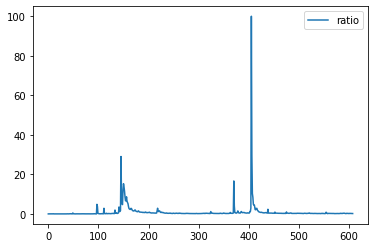

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm

jdata=json.loads(res)

print(len(jdata['results']))
pdata=jdata['results'][0]['data']
cjdf=pd.DataFrame.from_dict(pdata)
print(cjdf.head())

cjdf.plot()

- jdata['results'][0]['data']는 '기생충'의 'ratio'만을 가지고 온다

# 네이버 데이터랩 검색량 추출
- 네이버 데이터랩 검색량을 추출하는 함수를 정의한다.
- 함수에 키워드, 시작날짜, 종료날짜, 날짜간격을 인자로 받는다.

## makeQry 함수 정의
- 데이터 랩 API에 적용되는 body값을 맞춰주는 과정이다.

In [5]:
keywords=[['극한직업'],['사바하'],['걸캅스'],['기생충','봉준호','짜파구리'],['나쁜녀석들']]

def makeQry(keywords=[],sdate='',edate='',tunit='date'):
  res = []
  for word in keywords:
    dict={'groupName':word[0], 'keywords':word}
    res.append(dict)
  

  rdict={"startDate":sdate,
         "endDate":edate,
         "timeUnit":tunit,
         "keywordGroups":res}
  return json.dumps(rdict, ensure_ascii=False)

In [6]:
makeQry(keywords, '2019-01-01', '2020-08-30', 'date')

'{"startDate": "2019-01-01", "endDate": "2020-08-30", "timeUnit": "date", "keywordGroups": [{"groupName": "극한직업", "keywords": ["극한직업"]}, {"groupName": "사바하", "keywords": ["사바하"]}, {"groupName": "걸캅스", "keywords": ["걸캅스"]}, {"groupName": "기생충", "keywords": ["기생충", "봉준호", "짜파구리"]}, {"groupName": "나쁜녀석들", "keywords": ["나쁜녀석들"]}]}'

# Mynsearch 함수 정의
- makeQry함수로 만들어진 body값을 사용하여 raw data를 불러오는 함수 정의

In [7]:
def Mynsearch(keywords=[],sdate='',edate='',tunit='date'):
  client_id = "GjOIh9f0eos4ZlO0MuPJ"
  client_secret = "6D0DNFKlWz"
  url = "https://openapi.naver.com/v1/datalab/search";
 
  body = makeQry(keywords, sdate, edate, tunit)

  request = urllib.request.Request(url)
  request.add_header("X-Naver-Client-Id",client_id)
  request.add_header("X-Naver-Client-Secret",client_secret)
  request.add_header("Content-Type","application/json")
  response = urllib.request.urlopen(request, data=body.encode("utf-8"))
  rescode = response.getcode()
  if (rescode==200):
    response_body = response.read()
    res=response_body.decode('utf-8')
    #print(res)
  else:
    res='error'
    print("Error Code:" + rescode)
  return res

# MyDataLab 함수 정의
- `Mynsearch` 함수로 불러온 raw_data를 DataFrame화 시키는 함수 정의  
- 만들어진 DataFrame으로 시각화를 진행해본다.

In [10]:
keywords=[['극한직업'],['사바하'],['걸캅스'],['나쁜녀석들'],['백두산']] #['기생충','봉준호','짜파구리']  # 기생충 데이터는 월등하므로 비교가 잘 이뤄지지 않아 제외

5
               극한직업      사바하      걸캅스    나쁜녀석들      백두산
period                                                 
2019-01-01  0.51273  0.03758  0.01178  0.15669  0.14547
2019-01-02  0.59014  0.03655  0.01355  0.14220  0.11658
2019-01-03  0.57528  0.02870  0.00981  0.11350  0.10892
2019-01-04  5.09767  0.02758  0.01552  0.12453  0.10172
2019-01-05  1.13232  0.03300  0.01299  0.14248  0.08695


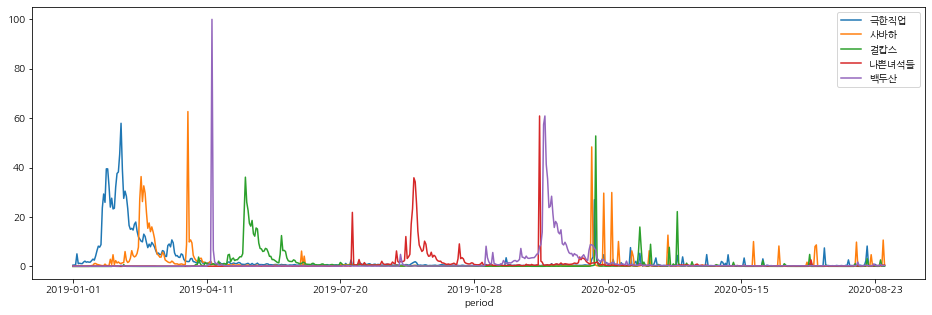

In [14]:
def MyDataLab(keywords=[],sdate='',edate='',tunit='date'):
  # 네이버 데이터랩 서치
  res=Mynsearch(keywords, sdate, edate, tunit)

  # 데이터 추출을 위한 json
  jdata=json.loads(res)

  print(len(jdata['results']))
  i=0;
  # 테이블 머지를 위한 기초테이블
  maindf=pd.DataFrame()

  # 키워드별로 컬럼명 지정
  for words in keywords:
    pdata=jdata['results'][i]['data']
    i += 1
    df=pd.DataFrame.from_dict(pdata)
    df.columns=["period",words[0]]
    df.set_index("period", inplace=True)
    maindf=pd.merge(maindf, df, how='outer', left_index=True, right_index=True)

  return maindf

mdf=MyDataLab(keywords, '2019-01-01', '2020-08-30', 'date')
print(mdf.head())  
plt.rcParams["figure.figsize"] = (16,5)
maindf.plot()
plt.show()